In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv("ausActivDescriptor_variables.csv")

In [3]:
df.head()

,info.brochures.destination,info.brochures.hotel,info.brochures.tour.operator,info.travel.agent,info.tourist.centre,info.advertising.newspapers,info.travel.guides,info.friends.relatives,info.work.colleagues,info.radio,...,info.exhibitions,info.slide.nights,book.internet,book.phone,book.at.destination,book.travel.agent,book.other,book.someone.else,spendpppd,TV.channel
0,1,0,0,1,1,0,1,1,1,0,...,0,0,0,1,1,0,0,0,2.000000,Pay TV
1,1,1,1,0,1,1,1,1,0,1,...,1,0,1,0,0,0,0,0,25.000000,Channel 7 (National)
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,1.071429,Channel 7 (National)
3,1,0,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,NaN,Pay TV
4,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,1,0,33.333333,Channel 9 (National)


In [5]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded = encoder.fit_transform(df.select_dtypes(include=['object']))
df_encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())

# Combine with numeric part
df_numeric = pd.concat([df.select_dtypes(include=[np.number]), df_encoded], axis=1)


In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
df_numeric_clean = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)


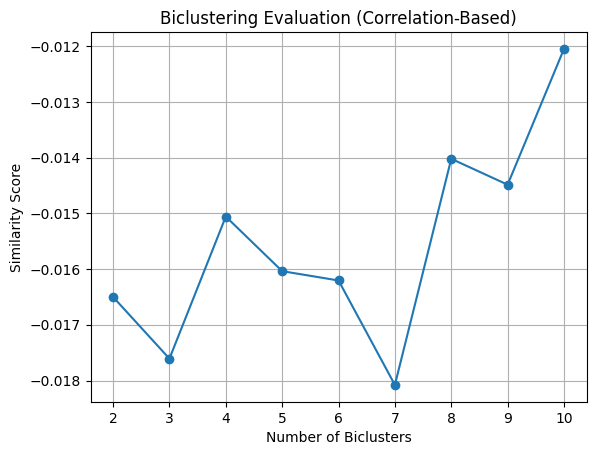

In [16]:
from sklearn.cluster import SpectralCoclustering
import matplotlib.pyplot as plt
import numpy as np

scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    model = SpectralCoclustering(n_clusters=n_clusters, random_state=0)
    model.fit(df_numeric_clean)

    # Reorder the matrix based on the row/column labels
    fit_data = df_numeric_clean.values[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]

    # Compare original and rearranged for rough consistency estimate
    original_data = df_numeric_clean.values
    score = np.corrcoef(original_data.ravel(), fit_data.ravel())[0, 1]  # Correlation as proxy
    scores.append(score)

# Plot the evaluation scores
plt.plot(range_n_clusters, scores, marker='o')
plt.xlabel("Number of Biclusters")
plt.ylabel("Similarity Score")
plt.title("Biclustering Evaluation (Correlation-Based)")
plt.grid(True)
plt.show()


In [22]:
from sklearn.cluster import SpectralCoclustering

# Force 12 clusters like in R
model = SpectralCoclustering(n_clusters=12, random_state=0)
model.fit(df_encoded)

# Assign cluster labels to rows
cl12 = np.full(df_encoded.shape[0], np.nan)
for k in range(model.n_clusters):
    cl12[model.rows_[k]] = k + 1  # R is 1-based, Python is 0-based

# Convert to Series
cl12_series = pd.Series(cl12, name="cl12")

# Frequency table including NaNs
counts = cl12_series.value_counts(dropna=False).sort_index()
print("Cluster membership counts (including unassigned):")
print(counts)


Cluster membership counts (including unassigned):
cl12
1.0     136
2.0     171
3.0     149
4.0     165
5.0      19
6.0      55
7.0     273
8.0      20
9.0      13
12.0      2
Name: count, dtype: int64


c:\Internship_project_2\envpr\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [23]:
# Assuming cl12 is a NumPy array or pandas Series of cluster labels
cl12_series = pd.Series(cl12, name="cl12")

# Create binary segment label
cl12_3 = pd.Series(
    np.where((~cl12_series.isna()) & (cl12_series == 3), "Segment 3", "Not Segment 3"),
    name="cl12_3"
)


In [24]:
cl12_3.value_counts()


cl12_3
Not Segment 3    854
Segment 3        149
Name: count, dtype: int64

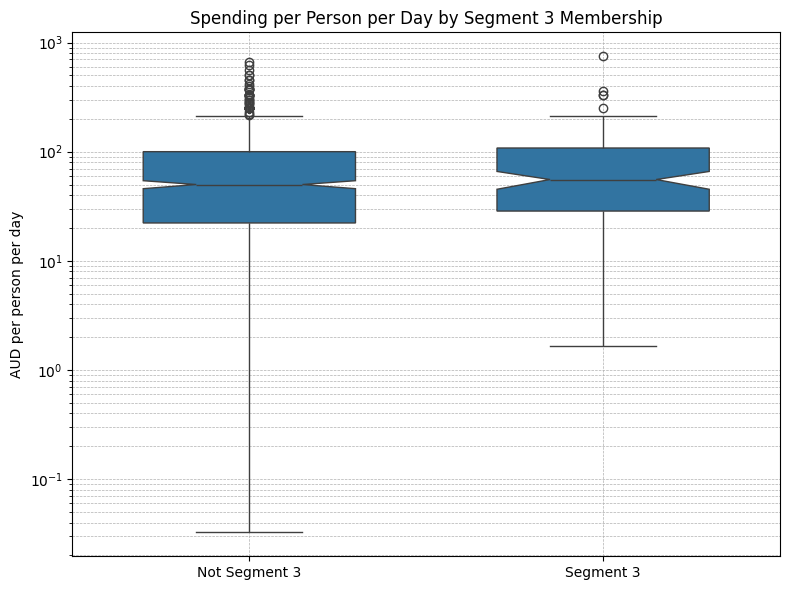

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge segment labels into your dataframe
df["cl12_3"] = cl12_3

# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="cl12_3", y="spendpppd", data=df, notch=True, width=0.6)
plt.yscale("log")  # log scale for y-axis
plt.ylabel("AUD per person per day")
plt.xlabel("")  # optional: leave blank like R default
plt.title("Spending per Person per Day by Segment 3 Membership")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


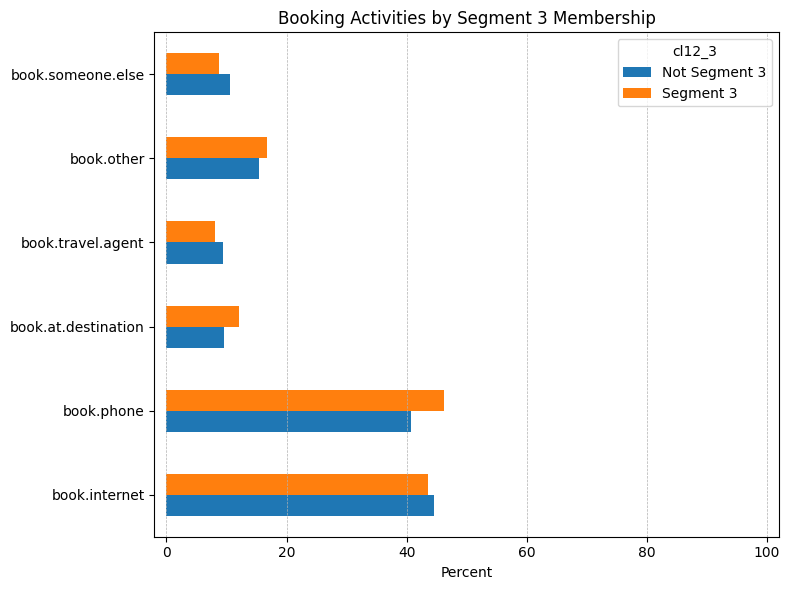

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Get all columns starting with "book"
book_cols = [col for col in df.columns if col.startswith("book")]

# Calculate proportions (percentage of '1's) within each group (Segment 3 vs Not Segment 3)
proportions = (
    df.groupby("cl12_3")[book_cols]
    .apply(lambda x: (x == 1).sum() / x.shape[0] * 100)
    .T  # Transpose for plotting
)

# Plot
proportions.plot(kind="barh", xlim=(-2, 102), figsize=(8, 6))
plt.xlabel("Percent")
plt.title("Booking Activities by Segment 3 Membership")
plt.grid(axis="x", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


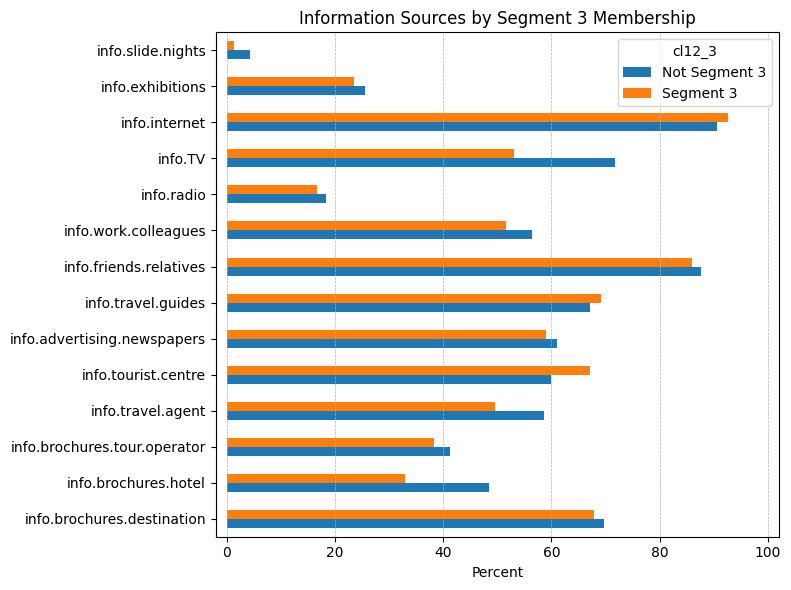

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Select columns starting with "info"
info_cols = [col for col in df.columns if col.startswith("info")]

# Calculate proportion of '1's in each group (Segment 3 vs Not Segment 3)
info_props = (
    df.groupby("cl12_3")[info_cols]
    .apply(lambda x: (x == 1).sum() / x.shape[0] * 100)
    .T  # Transpose for plotting
)

# Plot horizontal bar chart
info_props.plot(kind="barh", xlim=(-2, 102), figsize=(8, 6))
plt.xlabel("Percent")
plt.title("Information Sources by Segment 3 Membership")
plt.grid(axis="x", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
